# SPX Option Trading Strategy

## Benjamin Danziger

1. Get hourly values of VIX index for period 10th Nov 2022 to 1st Nov 2024

2. Get hourly values of SPY for period 10th Nov 2022 to 1st Nov 2024
3. Create a function to price a vanilla call/put on SPY given an SPY price, an implied vol, assuming interest rates and dividends are zero
4. Create a function to get the delta of a vanilla call/put on SPY given an SPY price, an implied vol, assuming interest rates and dividends are zero
5. We are going to assume that current VIX gives the 1W implied for SPY
6. Create a short gamma strat where you are short a 1W ATM Straddle on SPY and then you delta hedge the position
7. Keep track of your P&L and all trades over the period
8. You can choose any method you like when deciding when/if to sell options
9. You can implement any delta hedging scheme you want

In [1]:
# Import Modules
import yfinance as yf
import pandas as pd
from matplotlib import pyplot as plt
from option_pricing import Option
import numpy as np

In [2]:
# Define Start and End
# yfinance only permits hourly data for the last 730 days
# We are therefore bound by where our start and end could be
end = pd.Timestamp.today().normalize()
start = end - pd.Timedelta(days=729)

## Collecting and Cleaning Data

In [3]:
# Scraping and cleaning data
price_df = yf.download(
    ["^SPX", "^VIX"], start=start, end=end, interval="1h", multi_level_index=False
)["Close"]
price_df["^VIX"] = price_df["^VIX"].ffill() / 100
price_df.dropna(inplace=True)
price_df = price_df.tz_localize(None)
price_df

[*********************100%***********************]  2 of 2 completed


Ticker,^SPX,^VIX
Datetime,,
2022-11-16 14:30:00,3969.750000,0.2462
2022-11-16 15:30:00,3970.820068,0.2423
2022-11-16 16:30:00,3968.860107,0.2410
2022-11-16 17:30:00,3969.649902,0.2430
2022-11-16 18:30:00,3963.580078,0.2433
...,...,...
2024-11-13 16:30:00,6000.029785,0.1408
2024-11-13 17:30:00,6003.279785,0.1394
2024-11-13 18:30:00,5995.080078,0.1387


Text(0.5, 1.0, 'VIX vs SPX')

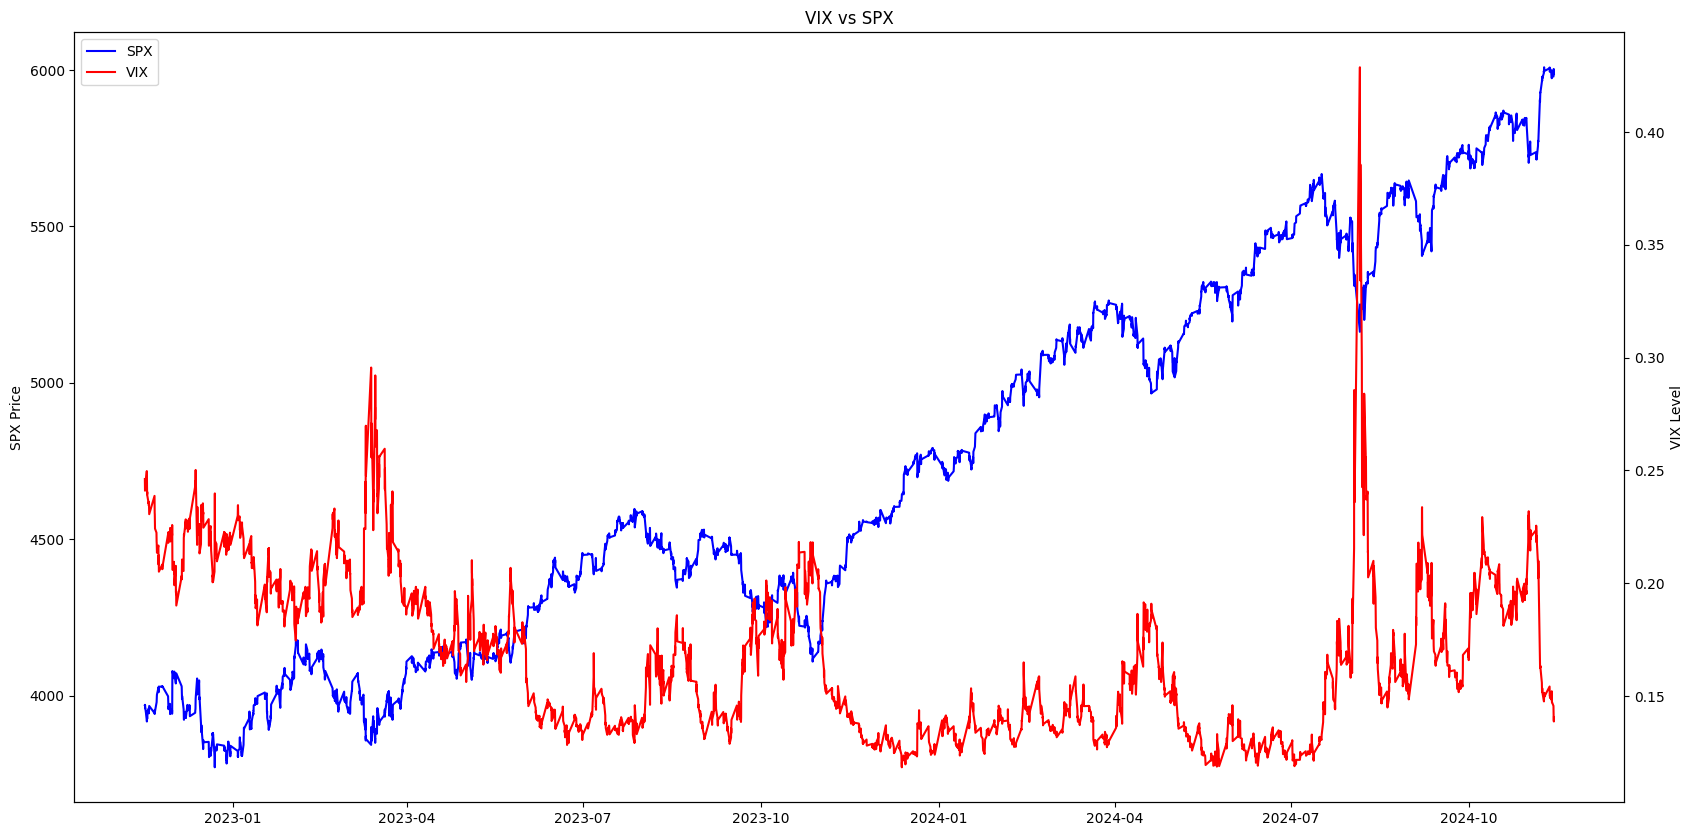

In [4]:
fig, ax = plt.subplots(figsize=(20, 10))
ln1 = ax.plot(price_df["^SPX"], label="SPX", color="blue")
ax.set_ylabel("SPX Price")
ax1 = ax.twinx()
ln2 = ax1.plot(price_df["^VIX"], label="VIX", color="red")
ax1.set_ylabel("VIX Level")
lns = ln1 + ln2
labs = [ln.get_label() for ln in lns]
ax.legend(lns, labs)
ax.set_title("VIX vs SPX")

## Building Option Pricing Model

I have built some option pricing models in the past (https://github.com/benisbuzz/option-pricing). I will use the pricing model from this repo for ease. please see option_pricing.py for details on pricing logic

In [5]:
# We are looking at 7 day options so lets set that here
DAYS_TO_EXPIRY = 7

In [6]:
# Set up some data storage
option_attributes = ["price", "delta", "gamma", "theta", "vega"]
num_of_attributes = len(option_attributes)
option_df = {
    f"{option_type}_{attribute}": []
    for option_type, attribute in zip(
        ["call"] * num_of_attributes + ["put"] * num_of_attributes,
        option_attributes * 2,
    )
}

# Now lets go through the df and price some ATM options for each hour
for i in range(len(price_df)):
    expiry = DAYS_TO_EXPIRY
    spot = price_df.iloc[i, 0]
    strike = price_df.iloc[i, 0]
    vol = price_df.iloc[i, 1]
    for option_type in ["call", "put"]:
        # See the Option class from option_pricing.py to see how this works
        option = Option(
            put_call=option_type[0].upper(),
            spot=spot,
            strike=strike,
            days_to_expiration=expiry,
            volatility=vol,
        )
        # Add the option details to the dict we defined above
        for attribute in option_attributes:
            option_df[f"{option_type}_{attribute}"].append(
                option.__getattribute__(attribute)
            )
option_df = pd.concat([price_df, pd.DataFrame(option_df, index=price_df.index)], axis=1)

In [7]:
option_df

,^SPX,^VIX,call_price,call_delta,call_gamma,call_theta,call_vega,put_price,put_delta,put_gamma,put_theta,put_vega
Datetime,,,,,,,,,,,,
2022-11-16 14:30:00,3969.750000,0.2462,55.508686,0.515773,0.002945,-14.863391,2.191473,52.464567,-0.484227,0.002945,-13.276708,2.191473
2022-11-16 15:30:00,3970.820068,0.2423,54.668743,0.515810,0.002992,-14.644860,2.192056,51.623802,-0.484190,0.002992,-13.057750,2.192056
2022-11-16 16:30:00,3968.860107,0.2410,54.356934,0.515823,0.003009,-14.563491,2.190971,51.313497,-0.484177,0.003009,-12.977164,2.190971
2022-11-16 17:30:00,3969.649902,0.2430,54.806030,0.515803,0.002984,-14.680475,2.191412,51.761987,-0.484197,0.002984,-13.093833,2.191412
2022-11-16 18:30:00,3963.580078,0.2433,54.787872,0.515800,0.002985,-14.675115,2.188061,51.748484,-0.484200,0.002985,-13.090899,2.188061
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-13 16:30:00,6000.029785,0.1408,48.991287,0.519577,0.003406,-13.381142,3.310875,44.390289,-0.480423,0.003406,-10.982970,3.310875
2024-11-13 17:30:00,6003.279785,0.1394,48.554053,0.519696,0.003438,-13.267771,3.312619,43.950563,-0.480304,0.003438,-10.868301,3.312619
2024-11-13 18:30:00,5995.080078,0.1387,48.256169,0.519756,0.003460,-13.189425,3.308070,43.658967,-0.480244,0.003460,-10.793232,3.308070


## Developing Trade Signals

We are going to design a simple strategy where, when the VIX moves above its 30 period moving average and the slope of said moving average is also negative, we sell a straddle. We will cover our position 5 hours after entering

The rationale behind this is that a breakout above the 30 moving average while the vix is historically moving down might indicate a false pop in vol. It is at these points where we would want to short vol.

In [107]:
# Pick an MA window
MA = 20
# Pick a holding period
HOLD_PERIOD_HOURS = 5

In [108]:
# Lets first simplify the data to what is needed

# Get straddle prices
straddle_price = option_df["call_price"] + option_df["put_price"]
straddle_price.name = "straddle_price"
strategy_df = pd.concat([price_df, straddle_price], axis=1)

# Get VIX moving average
strategy_df[f"VIX_{MA}_MA"] = strategy_df["^VIX"].rolling(MA).mean()

# Develop trade signals. Short a straddle if the VIX has moved above its moving average
# while the gradient of the moving average is negative. Remember to shift the series
# so it is not forward looking
strategy_df["entry_signal"] = (
    (strategy_df["^VIX"] > strategy_df[f"VIX_{MA}_MA"])
    & (strategy_df[f"VIX_{MA}_MA"].pct_change() < 0)
).shift(1)


In [109]:
# We are going to make some changes to the above df so lets make a copy
strategy_df_copy = strategy_df.dropna().copy()

# Store the results of the strategy
strategy_results = {"price": {}, "position": {}, "nominal_pnl": {}, "pct_pnl": {}}

counter = 0
# Create a while loop to iterate over the df. We cant use a for loop as we will be making
# changes to the df which wont get registered in a for loop
while counter < len(strategy_df_copy):
    # Check if we should be entering a trade
    if strategy_df_copy.iloc[counter, -1]:
        # If we are entering, set the entry date and price
        entry_date = strategy_df_copy.index[counter]
        entry_price = strategy_df_copy.iloc[counter, 2]

        # Hold for 5 hours (does not account for rolling over to next day)
        exit_date = strategy_df_copy.index[counter + HOLD_PERIOD_HOURS]

        # Calculate how long we have held the option for (important for pricing)
        days_held = (exit_date - entry_date).components.hours / 24
        # Calculate exit price. To do this we need to reprice the straddle
        # with the original strike but updated spot, time to expiry and volatility
        exit_price = 0
        for option_type in ["C", "P"]:
            exit_price += Option(
                put_call=option_type,
                # Todays spot
                spot=strategy_df_copy.loc[exit_date, "^SPX"],
                strike=strategy_df_copy.loc[entry_date, "^SPX"],
                # Less time to expiration
                days_to_expiration=DAYS_TO_EXPIRY - days_held,
                # New vol
                volatility=strategy_df_copy.loc[exit_date, "^VIX"],
            ).price

        # Save entry and exit dates
        strategy_results["position"][entry_date] = -1
        strategy_results["position"][exit_date] = 1

        # Save entry and exit prices
        strategy_results["price"][entry_date] = entry_price
        strategy_results["price"][exit_date] = exit_price

        # Save the PnL
        # The PnL will be entry - exit (as opposed to exit - entry) because we are short
        nominal_pnl = entry_price - exit_price
        strategy_results["nominal_pnl"][exit_date] = nominal_pnl
        strategy_results["pct_pnl"][exit_date] = nominal_pnl / entry_price

        # We need to make sure we cant enter another trade until the current one has been closed
        # We should therefore set all entry signals to false between the opening and closing
        # of the current trade
        strategy_df_copy.iloc[counter : counter + HOLD_PERIOD_HOURS + 1, -1] = False
    counter += 1

results_df = pd.DataFrame(strategy_results)
results_df.insert(0, "VIX", strategy_df["^VIX"])

In [110]:
results_df

,VIX,price,position,nominal_pnl,pct_pnl
2022-11-28 15:30:00,0.2195,96.758660,-1,NaN,NaN
2022-11-28 20:30:00,0.2211,97.323087,1,-0.564426,-0.005833
2022-12-05 18:30:00,0.2065,91.054599,-1,NaN,NaN
2022-12-06 16:30:00,0.2171,94.471022,1,-3.416422,-0.037521
2022-12-15 18:30:00,0.2347,100.709967,-1,NaN,NaN
...,...,...,...,...,...
2024-10-31 15:30:00,0.2300,156.835805,1,-26.716824,-0.205326
2024-11-11 15:30:00,0.1527,101.396079,-1,NaN,NaN
2024-11-11 20:30:00,0.1497,97.814652,1,3.581427,0.035321
2024-11-12 18:30:00,0.1476,97.813232,-1,NaN,NaN


Text(0.5, 1.0, 'Long vs Short Prices of Short Straddle Strategy')

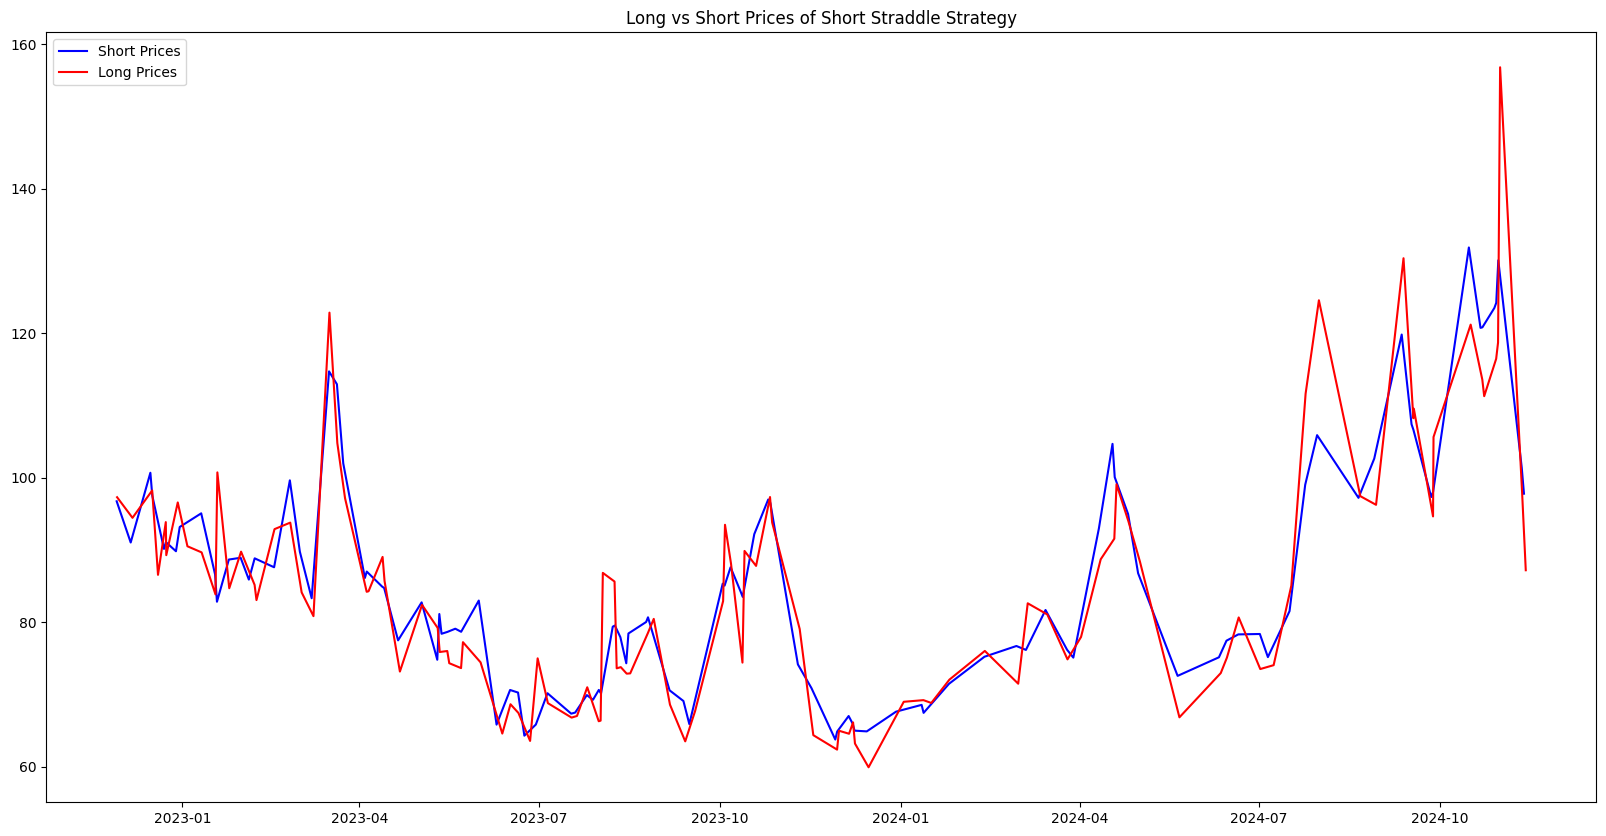

In [111]:
# Now lets look at the prices we short at vs the prices we long at
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(results_df[results_df["position"] == -1]["price"], color = "blue", label = "Short Prices")
ax.plot(results_df[results_df["position"] == 1]["price"], color = "red", label = "Long Prices")
ax.legend()
ax.set_title("Long vs Short Prices of Short Straddle Strategy")

Text(0.5, 1.0, '% Return on each trade in short straddle strategy')

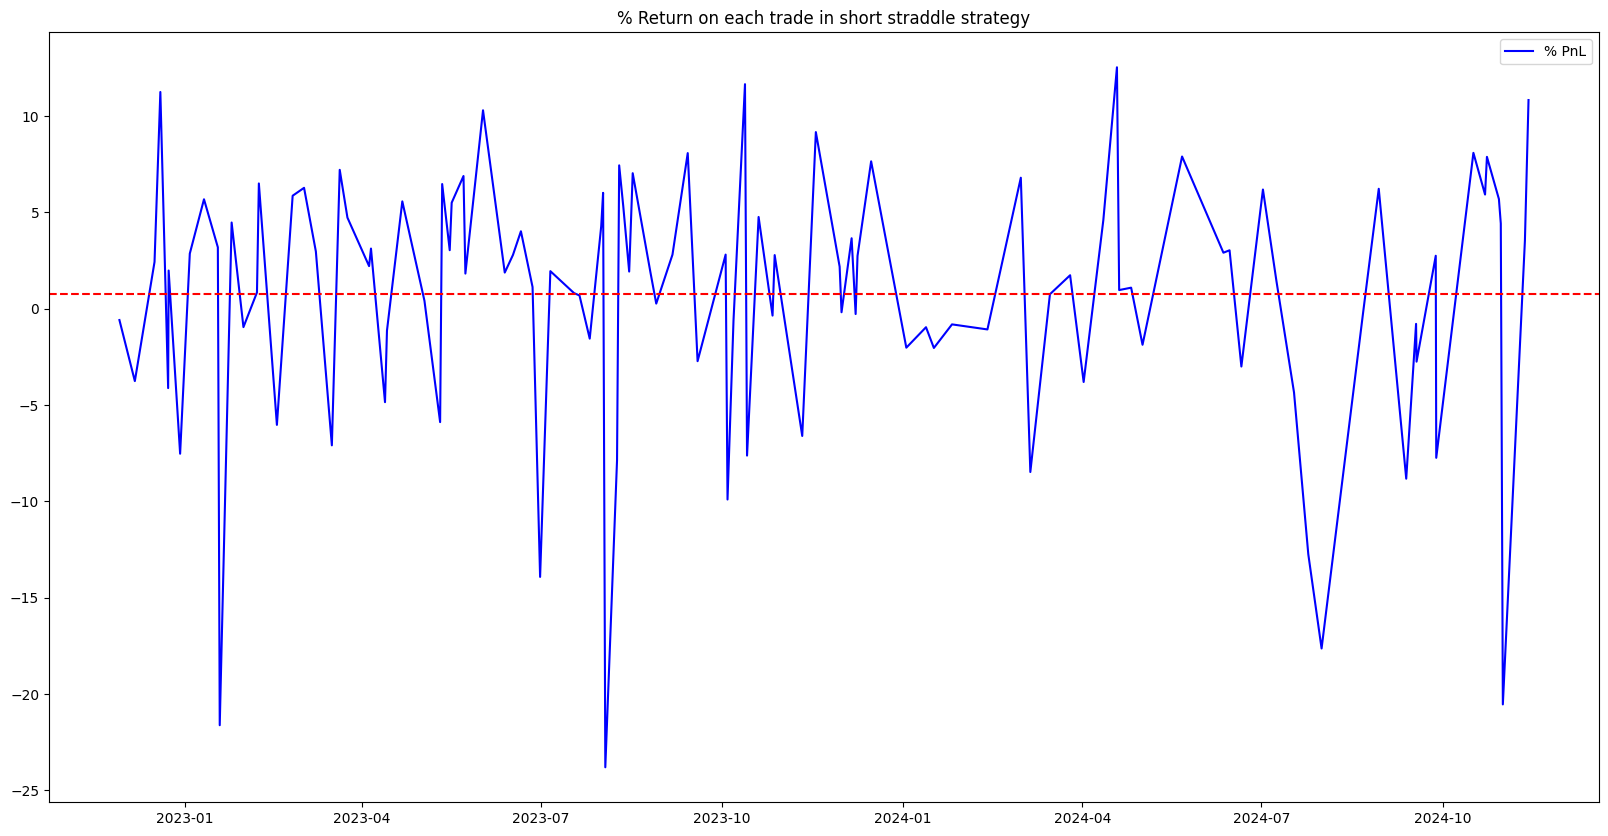

In [112]:
# Now lets look at the prices we short at vs the prices we long at
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(results_df["pct_pnl"].dropna() * 100, color = "blue", label = "% PnL")
ax.axhline(results_df["pct_pnl"].mean() * 100, color = "red", linestyle = "--")
ax.legend()
ax.set_title("% Return on each trade in short straddle strategy")

In [113]:
print(f"Number of trades: {int(len(results_df) / 2)}")

Number of trades: 112


In [114]:
# Check Average Returns
print(f"Average daily SPX return: {(price_df['^SPX'].pct_change().mean() * 100).round(4)}%")
print(f"Average short straddle trade return: {(results_df['pct_pnl'].mean() * 100).round(4)}%")


Average daily SPX return: 0.0123%
Average short straddle trade return: 0.7547%


In [115]:
results_df

,VIX,price,position,nominal_pnl,pct_pnl
2022-11-28 15:30:00,0.2195,96.758660,-1,NaN,NaN
2022-11-28 20:30:00,0.2211,97.323087,1,-0.564426,-0.005833
2022-12-05 18:30:00,0.2065,91.054599,-1,NaN,NaN
2022-12-06 16:30:00,0.2171,94.471022,1,-3.416422,-0.037521
2022-12-15 18:30:00,0.2347,100.709967,-1,NaN,NaN
...,...,...,...,...,...
2024-10-31 15:30:00,0.2300,156.835805,1,-26.716824,-0.205326
2024-11-11 15:30:00,0.1527,101.396079,-1,NaN,NaN
2024-11-11 20:30:00,0.1497,97.814652,1,3.581427,0.035321
2024-11-12 18:30:00,0.1476,97.813232,-1,NaN,NaN


In [116]:
# Growth of 100,000 USD
running_total = 100_000
totals = []
for i in range(len(results_df)):
    if results_df.iloc[i,2] == -1:
        # If we are going short, use half of our capital to short the straddle
        # Keep the other half in case of margin calls
        pos = int(running_total / results_df.iloc[i,1])
    elif results_df.iloc[i,2] == 1:
        # Calculate PnL by multiplying change in price of straddle by position size
        running_total += pos * results_df.iloc[i,3]
        totals.append(running_total)
# This gets the strategy return on trade days
strategy_return = pd.Series(totals, results_df[results_df["position"] == 1].index)
# Now lets make it daily
strategy_return = strategy_return.reindex(price_df.index)
strategy_return.iloc[0] = 100_000
strategy_return.ffill(inplace=True)


Text(0.5, 1.0, 'Growth of 100,000 USD in Strategy vs Buy and Hold')

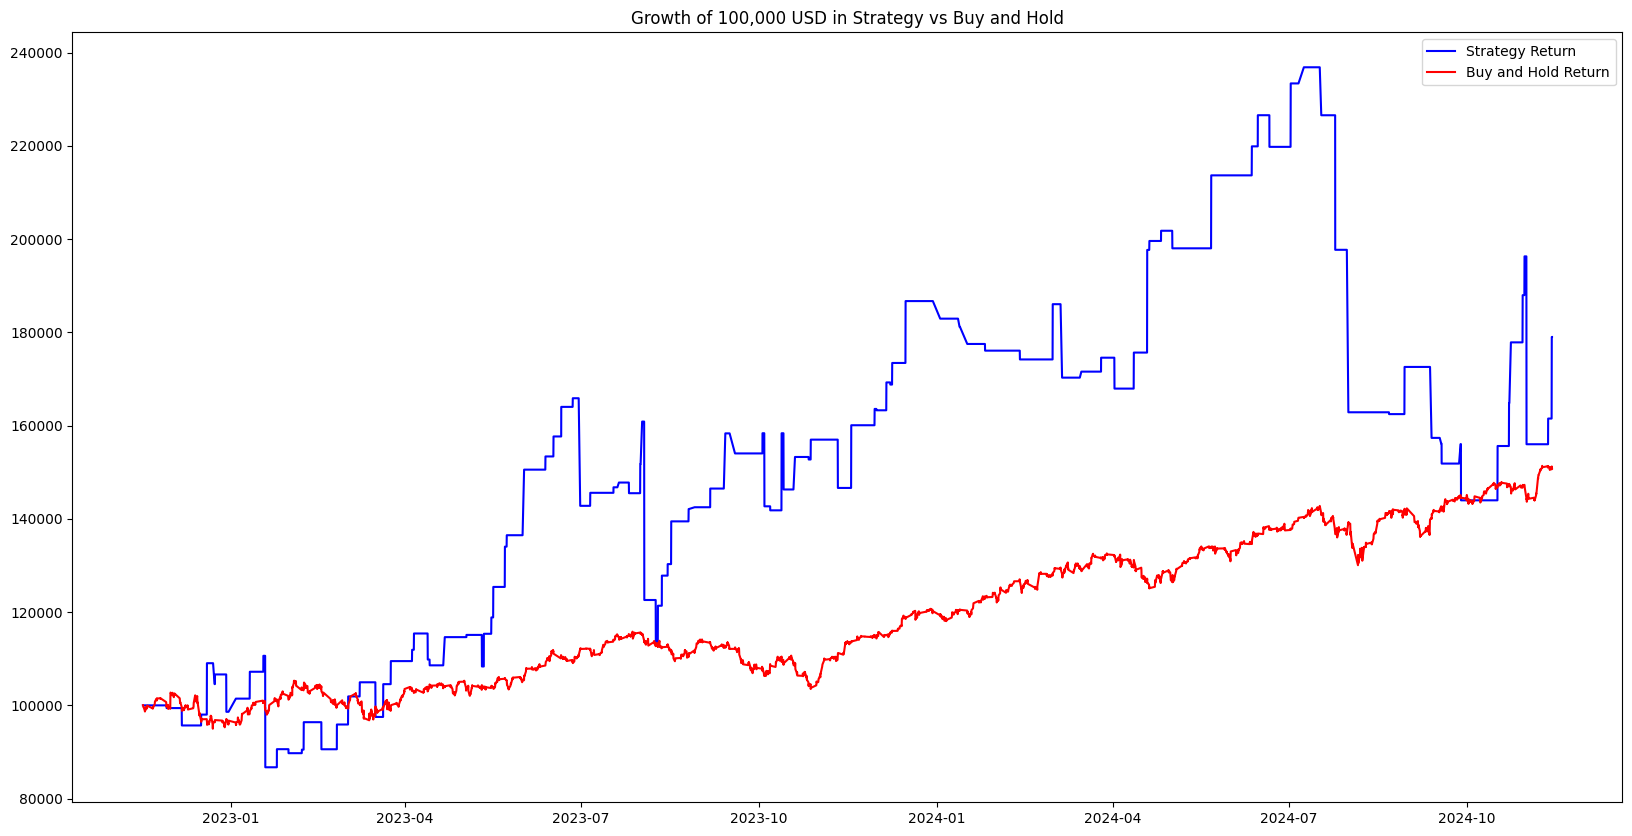

In [117]:
fig, ax = plt.subplots(figsize=(20, 10))

ax.plot(strategy_return, color = "blue", label = "Strategy Return")
ax.plot(100_000 * (1+price_df.iloc[:,0].pct_change()).cumprod(), color = "red", label = "Buy and Hold Return")
ax.legend()
ax.set_title("Growth of 100,000 USD in Strategy vs Buy and Hold")

In [118]:
print(f"Strategy Sharpe: {((strategy_return.pct_change().mean() / strategy_return.pct_change().std()) * np.sqrt(252)).round(2)}")
print(f"SPX Sharpe: {(price_df['^SPX'].pct_change().mean() / price_df['^SPX'].pct_change().std() * np.sqrt(252)).round(2)}")

Strategy Sharpe: 0.32
SPX Sharpe: 0.61


Text(0.5, 1.0, 'SPX vs VIX with Trade Markers')

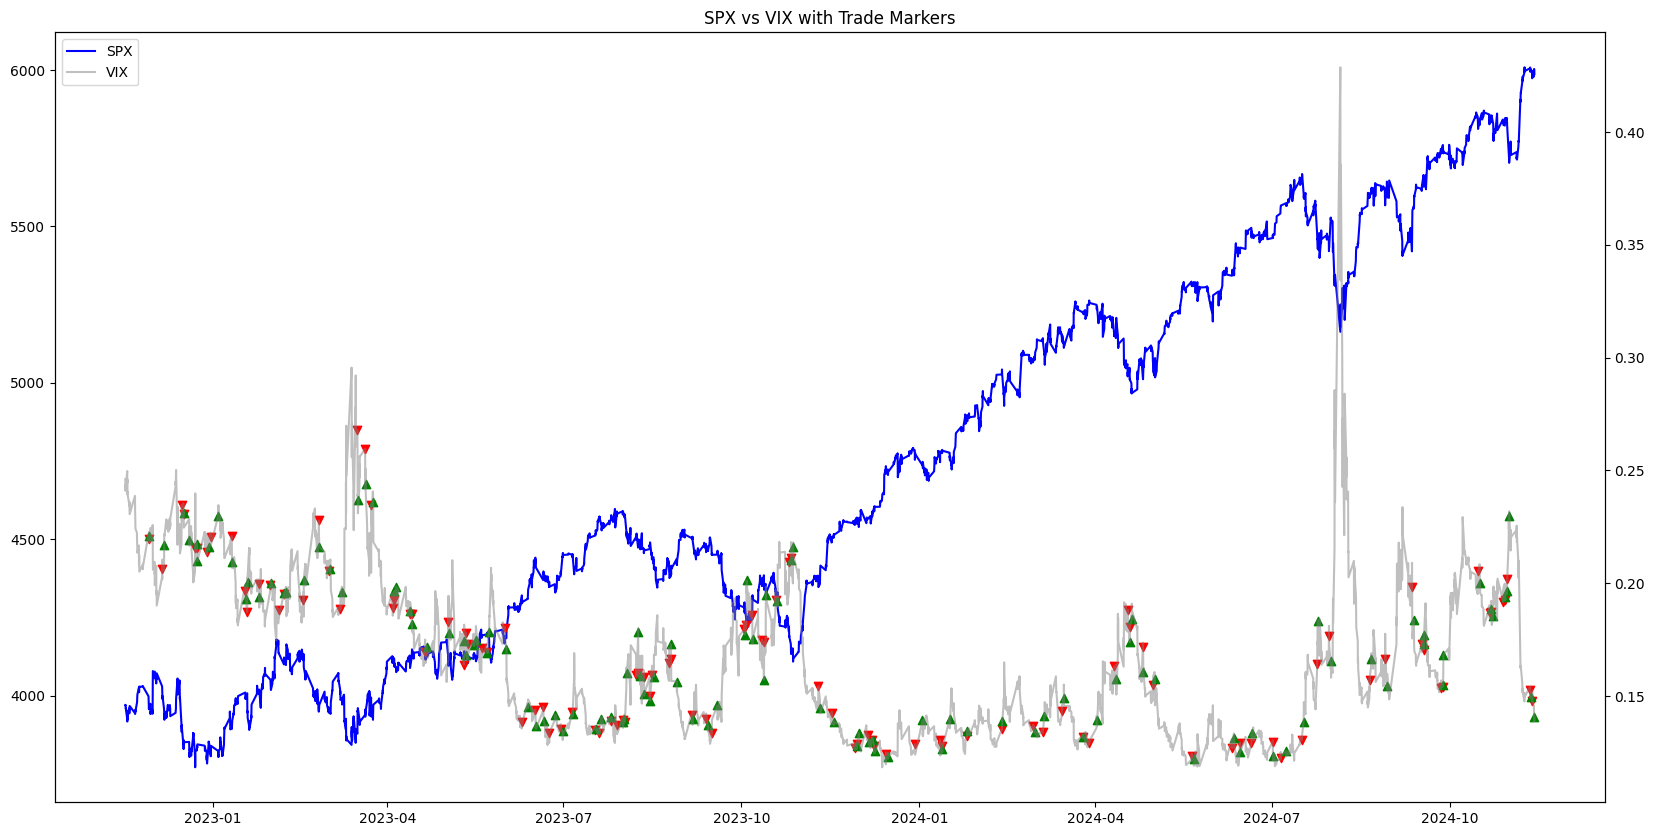

In [119]:
long_dates = results_df[results_df["position"] == 1].index
short_dates = results_df[results_df["position"] == -1].index
fig, ax = plt.subplots(figsize = (20,10))
ln1 = ax.plot(price_df["^SPX"], color = "blue", label = "SPX")
ax1 = ax.twinx()
ln2 = ax1.plot(price_df["^VIX"], color = "grey", alpha = 0.5, label = "VIX")
ln3 = ax1.scatter(short_dates, price_df["^VIX"].loc[short_dates], marker = "v", color = "red")
ln4 = ax1.scatter(long_dates, price_df["^VIX"].loc[long_dates], marker = "^", color = "green")

lns = ln1+ln2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs)

ax.set_title("SPX vs VIX with Trade Markers")

In [120]:
shorts = price_df["^VIX"].loc[short_dates].reset_index(drop=True)
longs = price_df["^VIX"].loc[long_dates].reset_index(drop = True)
print(f"There is a {round(float((shorts > longs).astype(int).mean())*100, 2)}% the VIX falls throughout the trade")

There is a 45.54% the VIX falls throughout the trade


This strategy demonstrates well that shorting vol is like picking up pennys next to a steam roller. It outperformed the SPX but got dramatically affected during big vol spikes